In [ ]:
import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier

# Definitions and Loading Dataset

- [Kaggle dataset link](https://www.kaggle.com/datasets/zeesolver/consumer-behavior-and-shopping-habits-dataset?resource=download)

In [28]:
#helping functions

# Define a custom aggregation function for boolean columns
def any_true(series: Series) -> bool:
    return series.any()

# Define a custom mode function for aggregation
def mode_agg(series: pd.Series) -> any:
    return series.mode().iloc[0]

# Define a function to remove outliers using the IQR method
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [29]:
# Global variables
RANDOM_STATE = 20241130

In [30]:
df = pd.read_csv('./kaggle_csv/shopping_behavior_updated.csv')
# replace all column names space with underscores and make them lowercase 
df.columns = df.columns.str.replace(' ', '_').str.lower()
# basic data cleaning
df = df.dropna().drop_duplicates()
numeric_columns = ['age', 'purchase_amount_(usd)', 'review_rating', 'previous_purchases']
# Remove outliers from the numeric columns
numeric_df = remove_outliers(df[numeric_columns])
df[numeric_columns] = numeric_df
print(f"Column names: {df.columns}")
print(f"Shape: {df.shape}")
df.head()

Column names: Index(['customer_id', 'age', 'gender', 'item_purchased', 'category',
       'purchase_amount_(usd)', 'location', 'size', 'color', 'season',
       'review_rating', 'subscription_status', 'shipping_type',
       'discount_applied', 'promo_code_used', 'previous_purchases',
       'payment_method', 'frequency_of_purchases'],
      dtype='object')
Shape: (3900, 18)


,customer_id,age,gender,item_purchased,category,purchase_amount_(usd),location,size,color,season,review_rating,subscription_status,shipping_type,discount_applied,promo_code_used,previous_purchases,payment_method,frequency_of_purchases
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually


# Prepare Product Table
- Since there is not product table and product ID, we are creating a new table for products and assign IDs

In [31]:
product_df = df.groupby(["item_purchased", "color", ]).agg({'category':'first', 
                                                            'purchase_amount_(usd)':'mean', 
                                                            'review_rating': 'mean', 
                                                            'discount_applied': any_true}).reset_index()
product_df = product_df.rename(columns={'purchase_amount_(usd)':'average_purchase_amount', 
                                        'review_rating':'average_review_rating', 
                                        'discount_applied':'has_discount'})
# assign a unique id to each product
product_df['product_id'] = product_df.index
# add product_id to the main dataframe
df = df.merge(product_df[['item_purchased', 'color', 'product_id']], on=['item_purchased', 'color'])
product_df.head()

,item_purchased,color,category,average_purchase_amount,average_review_rating,has_discount,product_id
0,Backpack,Beige,Accessories,63.000000,3.200000,True,0
1,Backpack,Black,Accessories,65.000000,3.827273,True,1
2,Backpack,Blue,Accessories,68.857143,3.971429,True,2
3,Backpack,Brown,Accessories,51.000000,3.900000,True,3
4,Backpack,Charcoal,Accessories,75.333333,4.133333,True,4


In [32]:
df.head()

,customer_id,age,gender,item_purchased,category,purchase_amount_(usd),location,size,color,season,review_rating,subscription_status,shipping_type,discount_applied,promo_code_used,previous_purchases,payment_method,frequency_of_purchases,product_id
0,1,55,Male,Blouse,Clothing,53,Kentucky,L,Gray,Winter,3.1,Yes,Express,Yes,Yes,14,Venmo,Fortnightly,57
1,2,19,Male,Sweater,Clothing,64,Maine,L,Maroon,Winter,3.1,Yes,Express,Yes,Yes,2,Cash,Fortnightly,587
2,3,50,Male,Jeans,Clothing,73,Massachusetts,S,Maroon,Spring,3.1,Yes,Free Shipping,Yes,Yes,23,Credit Card,Weekly,287
3,4,21,Male,Sandals,Footwear,90,Rhode Island,M,Maroon,Spring,3.5,Yes,Next Day Air,Yes,Yes,49,PayPal,Weekly,362
4,5,45,Male,Blouse,Clothing,49,Oregon,M,Turquoise,Spring,2.7,Yes,Free Shipping,Yes,Yes,31,PayPal,Annually,71


In [33]:
# save transaction df and product df
transaction_df = df.copy()
transaction_df.to_csv('./created_csv/transaction_df.csv', index=False)
product_df.to_csv('./created_csv/product_df.csv', index=False)

# Prepare Customer Table & Feature Engineering

- Create a seperate table for the customers
- Create new columns as engineered features for customer clustering

In [11]:
customer_df = df.groupby('customer_id').agg({'age':'first', 
                                             'gender':'first', 
                                             'purchase_amount_(usd)':'sum', 
                                             'location': mode_agg, 
                                             'previous_purchases': 'max', 
                                             'subscription_status': any_true,
                                             'size': mode_agg,
                                             'color': mode_agg,
                                             'subscription_status': any_true,
                                             'shipping_type': mode_agg,
                                             'promo_code_used': any_true,
                                             'payment_method': mode_agg,
                                             'review_rating': 'mean'}).reset_index()
customer_df['previous_purchases'] = customer_df['previous_purchases'] + 1
# make the column names more readable
customer_df = customer_df.rename(columns={'purchase_amount_(usd)':'total_purchase_amount', 
                                            'previous_purchases':'total_purchases', 
                                            'subscription_status':'is_subscriber',
                                            'shipping_type':'preferred_shipping',
                                            'promo_code_used':'used_promo_code',
                                            'payment_method':'preferred_payment_method',
                                            'size':'preferred_size',
                                            'color':'preferred_color',
                                            'review_rating':'average_review_rating'})
                                          
customer_df['average_purchase_amount'] = customer_df['total_purchase_amount'] / customer_df['total_purchases']
customer_df['average_purchase_amount'] = customer_df['average_purchase_amount'].replace(np.inf, 0)
print(f"Shape: {customer_df.shape}")
customer_df.head()

Shape: (3900, 14)


,customer_id,age,gender,total_purchase_amount,location,total_purchases,is_subscriber,preferred_size,preferred_color,preferred_shipping,used_promo_code,preferred_payment_method,average_review_rating,average_purchase_amount
0,1,55,Male,53,Kentucky,15,True,L,Gray,Express,True,Venmo,3.1,3.533333
1,2,19,Male,64,Maine,3,True,L,Maroon,Express,True,Cash,3.1,21.333333
2,3,50,Male,73,Massachusetts,24,True,S,Maroon,Free Shipping,True,Credit Card,3.1,3.041667
3,4,21,Male,90,Rhode Island,50,True,M,Maroon,Next Day Air,True,PayPal,3.5,1.800000
4,5,45,Male,49,Oregon,32,True,M,Turquoise,Free Shipping,True,PayPal,2.7,1.531250


# Preprocessing Customer DataFrame

In [12]:
# Define preprocessing function
def preprocess_data(df):
    label_encoder = LabelEncoder()
    scaler = StandardScaler()
    
    category_columns = ['location', 'preferred_size', 'preferred_color', 'preferred_shipping', 'preferred_payment_method']
    numeric_columns = ['age', 'total_purchase_amount', 'total_purchases', 'average_purchase_amount', 'average_review_rating']
    boolean_columns = ['is_subscriber', 'used_promo_code']
    feature_list = category_columns + numeric_columns + boolean_columns
    
    processed_df = df.copy()
    
    # Encode categorical columns
    for column in category_columns:
        processed_df[column] = label_encoder.fit_transform(processed_df[column])
    
    # Scale numerical columns
    processed_df[numeric_columns] = scaler.fit_transform(processed_df[numeric_columns])
    
    # Encode boolean columns
    processed_df[boolean_columns] = processed_df[boolean_columns].astype(int)
    
    return processed_df, feature_list

# Preprocess each subset
processed_df, feature_list = preprocess_data(customer_df)


# K-Means Clustering 
- K-Means: K-Means is a popular and widely used clustering algorithm that partitions a dataset into K distinct, non-overlapping subsets (clusters). The goal of K-Means is to minimize the variance within each cluster. 

- Use Elbow Method and Silhouette Score for determining the optimal number of clusters for  K-Means:

    - Elbow Method: Plot the within-cluster sum of squares (WCSS) against the number of clusters. The "elbow" point, where the rate of decrease sharply slows, indicates a good number of clusters.

    - Silhouette Score: Measures how similar an object is to its own cluster compared to other clusters. A higher silhouette score indicates better-defined clusters.

In [18]:
def plot_elbow_and_silhouette(processed_df, feature_list, random_state=20241130, title=None, min_clusters=2, max_clusters=10):
    wcss = []
    silhouette_scores = []

    for i in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, random_state=random_state, n_init=10, max_iter=1000)
        kmeans.fit(processed_df[feature_list])
        wcss.append(kmeans.inertia_)

        cluster_labels = kmeans.predict(processed_df[feature_list])
        silhouette_avg = silhouette_score(processed_df[feature_list], cluster_labels)
        silhouette_scores.append(silhouette_avg)

    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'Number of Clusters': range(2, 11),
        'WCSS': wcss,
        'Silhouette Score': silhouette_scores
    })

    # Plot WCSS and Silhouette Scores using Seaborn
    fig, ax1 = plt.subplots(figsize=(10, 6))

    sns.lineplot(x='Number of Clusters', y='WCSS', data=results_df, marker='o', ax=ax1, color='blue')
    ax1.set_ylabel('WCSS', color='blue')
    ax1.set_xlabel('Number of Clusters')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    sns.lineplot(x='Number of Clusters', y='Silhouette Score', data=results_df, marker='o', ax=ax2, color='green')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    if title:
        plt.title(title)
    else:
        plt.title('Elbow Method and Silhouette Score for Optimal Number of Clusters')
    plt.show()


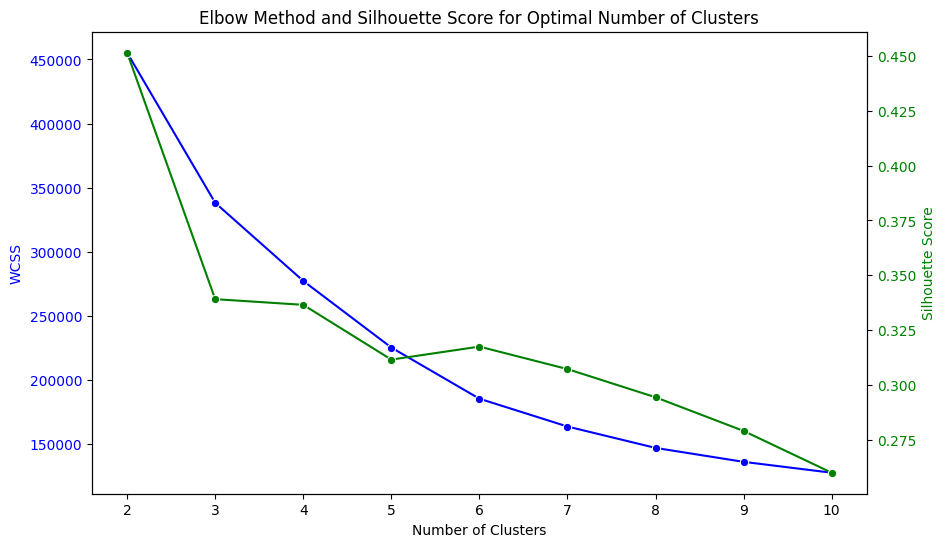

In [19]:
plot_elbow_and_silhouette(processed_df, feature_list, random_state=RANDOM_STATE)


We can notice that the Elbow point is `num_clusters = 5`, the Silhouette Scores at the point is also acceptable.

# Optimal K-Means and PCA Visualization

In [20]:
def visualize_clusters(processed_df, feature_list, method='pca', random_state=20241130):
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=random_state)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=random_state)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")

    reduced_components = reducer.fit_transform(processed_df[feature_list])
    processed_df['component_1'] = reduced_components[:, 0]
    processed_df['component_2'] = reduced_components[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='component_1', y='component_2', hue='cluster', palette='viridis', data=processed_df)
    plt.title(f'Customer Segmentation Clustering Results ({method.upper()})')
    plt.xlabel(f'{method.upper()} Component 1')
    plt.ylabel(f'{method.upper()} Component 2')
    plt.legend(title='Cluster')
    plt.show()

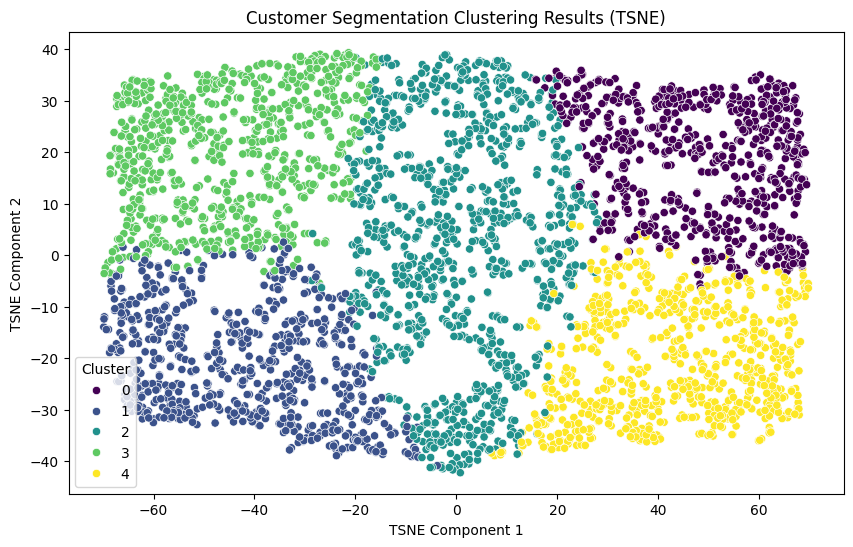

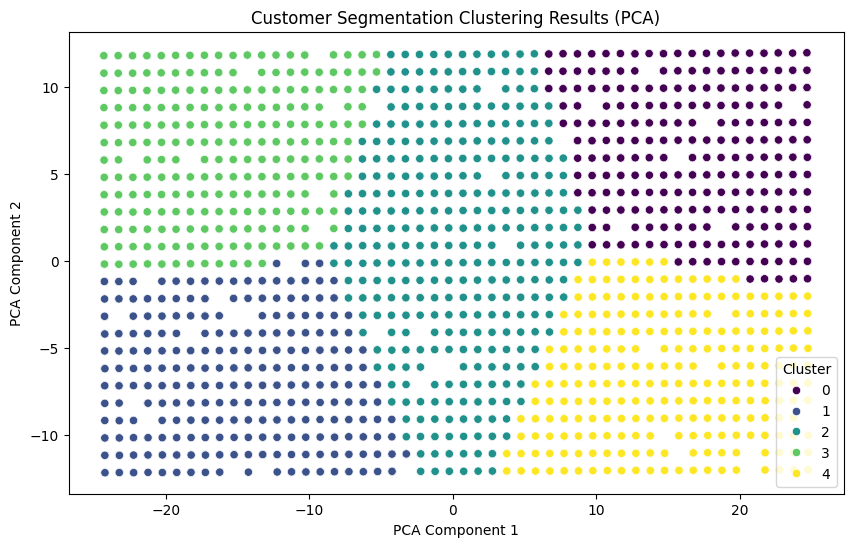

In [21]:
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE, n_init=10, max_iter=1000)
processed_df['cluster'] = kmeans.fit_predict(processed_df[feature_list])
visualize_clusters(processed_df, feature_list, method='tsne', random_state=RANDOM_STATE)
visualize_clusters(processed_df, feature_list, method='pca', random_state=RANDOM_STATE)


# Naive Customer Segmentation by K-means Results
- Directly apply the Kmeans results
- get summary
- Save as csv files

In [22]:
# join the tables
clustered_customer_df = customer_df.copy().merge(processed_df[['customer_id', 'cluster']], on='customer_id')


In [23]:
cluster_summary = clustered_customer_df.groupby(['cluster', 'gender']).agg({
    'age': ['mean', 'std'],
    'gender': mode_agg,
    'total_purchase_amount': ['mean', 'std'],
    'location': mode_agg,
    'total_purchases': ['mean', 'std'],
    'is_subscriber': mode_agg,
    'preferred_size': mode_agg,
    'preferred_color': mode_agg,
    'preferred_shipping': mode_agg,
    'used_promo_code': mode_agg,
    'preferred_payment_method': mode_agg,
    'average_review_rating': ['mean', 'median', 'min', 'max']
}).reset_index()

# Flatten the MultiIndex columns
cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]

# Display the cluster summary
display(cluster_summary)

,cluster_,gender_,age_mean,age_std,gender_mode_agg,total_purchase_amount_mean,total_purchase_amount_std,location_mode_agg,total_purchases_mean,total_purchases_std,is_subscriber_mode_agg,preferred_size_mode_agg,preferred_color_mode_agg,preferred_shipping_mode_agg,used_promo_code_mode_agg,preferred_payment_method_mode_agg,average_review_rating_mean,average_review_rating_median,average_review_rating_min,average_review_rating_max
0,0,Female,44.295652,14.837091,Female,59.547826,23.601215,Utah,25.647826,14.312250,True,M,Yellow,Free Shipping,True,Credit Card,3.809130,3.8,2.5,5.0
1,0,Male,44.240909,15.156020,Male,60.465909,23.458269,Wisconsin,25.827273,14.105272,True,M,Silver,Express,True,Credit Card,3.771591,3.8,2.5,5.0
2,1,Female,43.160870,14.409035,Female,59.639130,23.689314,California,26.839130,15.082169,True,M,Brown,Express,True,PayPal,3.727826,3.8,2.5,5.0
3,1,Male,43.507216,15.772742,Male,58.012371,23.692064,Illinois,27.515464,14.457485,True,M,Black,Express,True,Cash,3.737320,3.7,2.5,5.0
4,2,Female,43.281734,15.396757,Female,61.284830,23.358122,Montana,25.786378,14.051841,True,M,Magenta,Standard,True,Credit Card,3.725077,3.7,2.5,5.0
5,2,Male,44.067321,15.536418,Male,58.653576,23.672313,Missouri,26.889201,14.201610,True,M,Olive,Free Shipping,True,Debit Card,3.751332,3.7,2.5,5.0
6,3,Female,44.483740,14.549204,Female,59.390244,23.930046,Idaho,25.422764,14.839554,True,M,Olive,Free Shipping,True,Credit Card,3.730488,3.7,2.5,5.0
7,3,Male,44.509766,14.749304,Male,58.773438,23.463079,Indiana,26.619141,14.302213,True,M,Yellow,Express,True,Credit Card,3.792187,3.8,2.5,5.0
8,4,Female,45.127854,15.446626,Female,61.063927,22.573540,Texas,24.150685,14.790591,True,M,Cyan,Free Shipping,True,Cash,3.721005,3.7,2.5,5.0
9,4,Male,44.163347,15.367917,Male,62.225100,24.606507,Vermont,26.527888,14.841754,True,M,Brown,2-Day Shipping,True,Credit Card,3.719323,3.7,2.5,5.0


In [24]:
# save each cluster to a csv file
for cluster_id in range(5):
    cluster_df = clustered_customer_df[clustered_customer_df['cluster'] == cluster_id]
    cluster_df.to_csv(f'./created_csv/customer_cluster_{cluster_id}_df.csv', index=False)

# Backward Engineering: Use Decision Tree Algorithm to Find Feature Importance
- Trying to find the key features to do the customer segmentation

/var/folders/bw/jlsgk0q15tb2gm1yn57nh8wm0000gn/T/ipykernel_11462/666385266.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


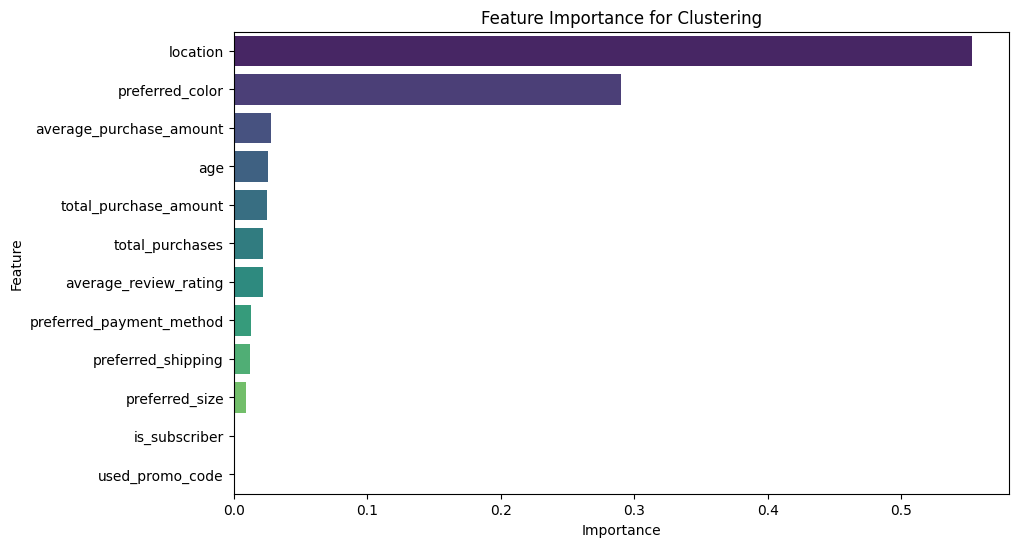

In [27]:
from sklearn.ensemble import RandomForestClassifier

def get_feature_importance(processed_df, feature_list):
    # Train a RandomForestClassifier to determine feature importance
    rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE)
    rf.fit(processed_df[feature_list], processed_df['cluster'])
    
    # Get feature importances
    feature_importances = rf.feature_importances_
    
    # Create a DataFrame for better visualization
    importance_df = pd.DataFrame({
        'Feature': feature_list,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)
    
    return importance_df

def plot_feature_importance(importance_df):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title('Feature Importance for Clustering')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

# Example usage
importance_df = get_feature_importance(processed_df, feature_list)
# save the feature importance to a csv file
importance_df.to_csv('./created_csv/customer_feature_importance.csv', index=False)
plot_feature_importance(importance_df)
